# ChordGAN

ChordGAN importing the models from a py file

In [1]:
# Initial setup to be able to load `src.preprocess`
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

from src.preprocess import load_data

%load_ext lab_black
%load_ext tensorboard

# python script, in github repo
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)

TF version: 2.6.0
Keras version: 2.6.0
Numpy version: 1.21.2


## Load data

In [3]:
fpath = os.path.join(top_dir, "../data/ChordGAN")
# fpath = os.path.join(top_dir, "../data/midi-world")
genre = "jazz"

dataset, (songs, names) = load_data(fpath, genre=genre, shuffle=False)

Creating TF dataset from the loaded songs
Creating TF dataset from the loaded songs
Complete.


In [4]:
sample_songs = []
sample_chromas = []
sample_names = names[:10]

for s, c in dataset.take(10):
    sample_songs.append(s.numpy())
    sample_chromas.append(c.numpy())

Let's peek at the chromas

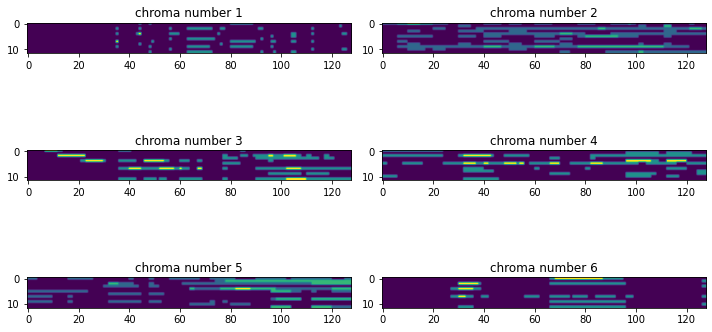

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (chroma, ax) in enumerate(zip(sample_chromas[:10], axes.flatten())):
    ax.set_title(f"chroma number {i+1}")
    ax.imshow(chroma[:, :128].T, cmap="viridis")
plt.tight_layout()
plt.show()

And at the songs

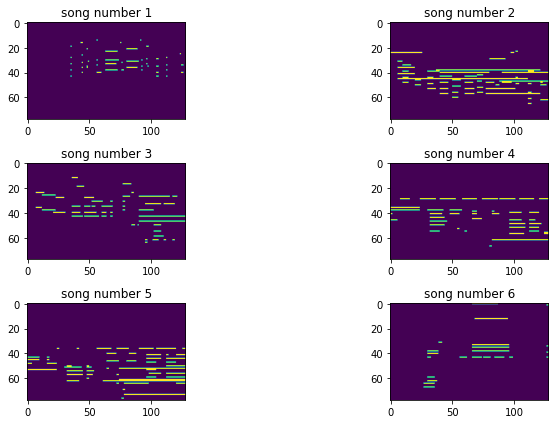

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, (song, ax) in enumerate(zip(sample_songs[:10], axes.flatten())):
    ax.set_title(f"song number {i+1}")
    ax.imshow(song[:, :128].T, cmap="viridis")
plt.tight_layout()
plt.show()

# Training

In [7]:
from src.model import ChordGAN
import time
import io


def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def log_progress(epoch, logs):
    """Logs the learning progress in the form of treating the midi files as images."""
    display_length = 412
    transfer_outputs = [cgan.generator(chroma) for chroma in sample_chromas]

    fig, axes = plt.subplots(10, 3, figsize=(15, 20))

    for (ax1, ax2, ax3), original, input_chroma, transfer, name in zip(
        axes, sample_songs, sample_chromas, transfer_outputs, names
    ):
        song_name = os.path.split(name)[-1].replace(".mid", "")

        ax1.imshow(original[0, :display_length].T)
        ax1.set_title(song_name)
        ax1.axis("off")

        ax2.imshow(input_chroma[0, :display_length].T)
        ax2.set_title("input_chroma")
        ax2.axis("off")

        ax3.imshow(transfer[0, :display_length].numpy().T, cmap="viridis")
        ax3.set_title("transfer")
        ax3.axis("off")

    fig.tight_layout()
    with img_writer.as_default():
        tf.summary.image("Genre transfer progress", plot_to_image(fig), step=epoch)


root_logdir = os.path.join(top_dir, "training_logs")


def get_run_logdir(genre, n_epochs, batch_size):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    model_info = "{}_{}e_bs{}_{}".format(genre, n_epochs, batch_size, run_id)
    return os.path.join(root_logdir, model_info), model_info

In [8]:
cgan = ChordGAN(note_range=78)
cgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
)

n_epochs = 10
batch_size = 64

logdir, model_info = get_run_logdir(genre, n_epochs, batch_size)
img_writer = tf.summary.create_file_writer(logdir + "/img")

In [9]:
callbacks = [
    TensorBoard(logdir),
    tf.keras.callbacks.LambdaCallback(on_epoch_end=log_progress),
]
cgan.fit(dataset, batch_size=batch_size, epochs=n_epochs, callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 4s 23ms/step - d_loss: 0.6413 - g_loss: 20.5456
Epoch 2/10
100/100 [==============================] - 2s 17ms/step - d_loss: 0.7829 - g_loss: 12.5747
Epoch 3/10
100/100 [==============================] - 2s 17ms/step - d_loss: 0.8082 - g_loss: 11.0963
Epoch 4/10
100/100 [==============================] - 2s 16ms/step - d_loss: 0.6599 - g_loss: 10.3586
Epoch 5/10
100/100 [==============================] - 2s 18ms/step - d_loss: 0.5669 - g_loss: 9.8303
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - d_loss: 0.4611 - g_loss: 9.4435
Epoch 7/10
100/100 [==============================] - 2s 19ms/step - d_loss: 0.3911 - g_loss: 9.1487
Epoch 8/10
100/100 [==============================] - 2s 17ms/step - d_loss: 0.3414 - g_loss: 8.9784
Epoch 9/10
100/100 [==============================] - 2s 20ms/step - d_loss: 0.2998 - g_loss: 8.8746
Epoch 10/10
100/100 [==============================] - 2s 16ms/step - d_loss: 0.2560 - 

In [10]:
cgan.save_weights(f"../trained_models/weights/{model_info}/")

Naturally it doesn't make sense to look at this as an image but it at least shows the result is close enough

# Style Transfer

In [20]:
from reverse_pianoroll import piano_roll_to_pretty_midi
from src.model import ChordGAN

new_cgan = ChordGAN(note_range=78)
new_cgan.load_weights(f"../trained_models/weights/{model_info}/")

Load data for transfer

In [12]:
transfer_genre = "classical"
new_ds, (songs, names) = load_data(
    fpath, transfer_genre, shuffle=False, note_range=(24, 102)
)

c:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Creating TF dataset from the loaded songs
Creating TF dataset from the loaded songs
Complete.


In [15]:
import os

dir_name = f"../converted_songs/{model_info}"
os.makedirs(dir_name, exist_ok=True)

for idx, ((_, chroma), song, name) in enumerate(zip(new_ds, songs, names)):
    name = os.path.split(name)[-1].split(".")[0]
    transfer = new_cgan(chroma)
    transfer.write(f"{dir_name}/{name}_{idx}_transfer.midi")